This example is similar to the square-patch example, but the object has lower symmetry. This is important because for the square patch, a rotation can also be described as a translation. For a more complex object (without rotational symmetry), this equivalence does not hold.

We will make a simple toy space that has a few non-trivial features. We place an object ("F") with intensity $I$ centered at position $(r, \theta)$ where
\begin{align}
%
    \theta &\sim \mathrm{Unif}[0, 2 \pi] \\
    r &\sim \mathcal{N}( \mu, \sigma^2 ) \\
    I &\sim \mathrm{Cat}(K, p)
%
\end{align}
to start $K = [1, 2]$ and $p = [0.5, 0.5]$, ie the square has a 50/50 chance of being "bright" or "dim".

Then we also optionally add some white Gaussian noise $\mathcal{N}(0, \epsilon^2)$ to every pixel in the receptive field.

In [1]:
import numpy as np
import h5py
from scipy import ndimage
from matplotlib import pyplot as plt

In [2]:
# model parameters

field_shape = (32+1, 32+1)
n_samples   = 24800

a       = 1 # box size
mu      = 0.0
sigma   = 2.0
K       = np.array([1,1])  # np.array([1, 2])
p       = np.ones(len(K)) / float(len(K))
epsilon = 0.0

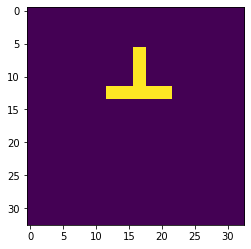

In [3]:
# make the "falsum" object

base_object = np.zeros(field_shape)

base_object[0:8,4:6] = 1 # middle vertical stroke
base_object[6:8,0:10] = 1 # bottom horizontal stroke
#base_object[4:8,8:10] = 1 # right vertical stroke

base_object = np.roll(base_object, 6, axis=0)
base_object = np.roll(base_object, 12, axis=1)

plt.figure()
plt.imshow(base_object)
plt.show()

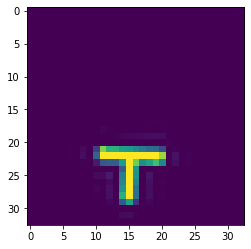

In [4]:
def rototrans(image, r, theta):
    """
    1. Translate image by `r` vertically, 
    2. Rotate by `theta` around center of the image
    3. Clamp image output to [0,1]
    """
    rt_image = ndimage.shift(image, (r,0)) # shift axis 0
    rt_image = ndimage.rotate(rt_image, np.degrees(theta), 
                              order=5, reshape=False)
    rt_image[rt_image < 0.0] = 0.0
    rt_image[rt_image > 1.0] = 1.0
    return rt_image

rt = rototrans(base_object, -2.5, np.random.rand()*2.0*np.pi)

plt.figure()
plt.imshow(rt)
plt.show()

In [6]:
# generate some images

data = np.zeros((n_samples,) + field_shape)

rs     = []
thetas = []
Is     = []

for s in range(n_samples):
    
    # draw from our distributions
    r     = np.random.randn(1)[0] * sigma + mu
    theta = np.random.uniform(0, 2.0*np.pi)
    #theta = np.random.uniform(0, 1.5*np.pi)
    I     = np.random.choice(K, p=p)
    
    rs.append(r)
    thetas.append(theta)
    Is.append(I)
    
    # compute the center pixel of the patch
    data[s] = rototrans(base_object * I, r, theta)
    
    # add noise
    data[s] += epsilon * np.random.randn(*field_shape)

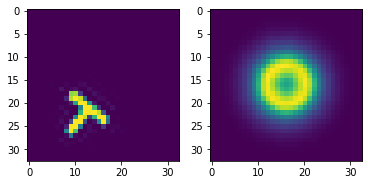

In [7]:
plt.figure()
plt.subplot(121)
plt.imshow(data[np.random.randint(0,n_samples)].T)
plt.subplot(122)
plt.imshow(data.mean(0).T)
plt.show()

In [8]:
# save the simulation as an HDF5 image stack
# put the parameters inside for safe keeping :)

f = h5py.File('bot_circle_sigma%.2f.h5' % sigma, 'w')

f['data'] = data

f['r']     = np.array(rs)
f['theta'] = np.array(thetas)
f['I']     = np.array(Is)

f['params/a']       = a
f['params/mu']      = mu
f['params/sigma']   = sigma
f['params/K']       = K
f['params/p']       = p
f['params/epsilon'] = epsilon

f.close()

For a second toy model, we break the orthogonality of $r$ and $\theta$ by introducing a dependency,
\begin{align}
%
    \theta &\sim \mathrm{Unif}[0, 2 \pi] \\
    r &\sim \mathcal{N}( \mu \sqrt{ \cos^2 \theta + \frac{1}{2} \sin^2 \theta}, \sigma^2 ) \\
    I &\sim \mathrm{Cat}(K, p)
%
\end{align}
Now, the radius changes as a function of the angle. This means that the resulting distribution of the cube is elliptical. 

In [112]:
# model parameters are the same as before

In [15]:
# generate some images
n_samples = 30
sigma     = 2.0
skew      = 0.66

data = np.zeros((n_samples,) + field_shape)

thetas = []
rs     = []
Is     = []

for s in range(n_samples):
    
    # draw from our distributions
    theta = np.random.uniform(0, 2.0*np.pi)
    mu_s  = 10.0 * (np.sqrt((1-skew) * np.cos(theta)**2 + (1+skew) * np.sin(theta)**2) - 1)
    r     = np.random.randn(1)[0] * sigma + mu_s
    I     = np.random.choice(K, p=p)
    
    rs.append(r)
    thetas.append(theta)
    Is.append(I)
    
    # compute the center pixel of the patch
    data[s] = rototrans(base_object * I, r, theta)
    
    # add noise
    data[s] += epsilon * np.random.randn(*field_shape)

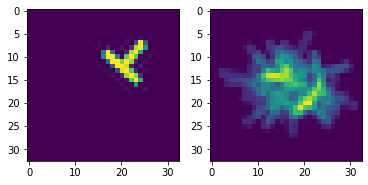

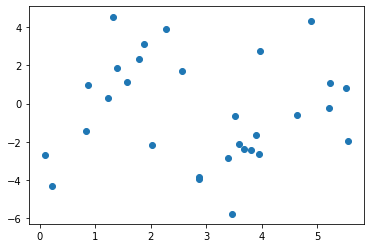

In [16]:
plt.figure()
plt.subplot(121)
plt.imshow(data[0])
plt.subplot(122)
plt.imshow(data.mean(0).T)
plt.show()

plt.figure()
plt.scatter(thetas, rs)
plt.show()

In [17]:
# save the simulation as an HDF5 image stack
# put the parameters inside for safe keeping :)

f = h5py.File('bot_ellipse_sigma%.2f.h5' % sigma, 'w')

f['data'] = data

f['r']     = np.array(rs)
f['theta'] = np.array(thetas)
f['I']     = np.array(Is)

f['params/a']       = a
f['params/mu']      = mu
f['params/sigma']   = sigma
f['params/K']       = K
f['params/p']       = p
f['params/epsilon'] = epsilon

f.close()